# Cloud DCGAN

## Setup

In [2]:
# imports
import sagemaker
import boto3
import argparse
import json
import os
import sys
import pandas as pd
import torch
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sagemaker.pytorch import PyTorch
import config
from train.model import DataDiscriminator, DataGenerator
from train.train import weights_init_normal, train

In [3]:
# directories
imgs_path = '/Volumes/SKYFLASH/fromReddit/'
model_dir = '/Volumes/SKYFLASH/models/'
# imgs_path = '../fromReddit/'
# model_dir = '../models/'

# model hyperparameters
# chosen based on https://arxiv.org/pdf/1511.06434.pdf
batch_size = 32
img_size = 32
z_size = 100
conv_dim = img_size
lr = 0.0002
beta1 =0.5
beta2 = 0.999
epochs = 5

In [4]:
# sagemaker session

sagemaker_session = sagemaker.Session(boto3.session.Session(
    aws_access_key_id=config.aws_access_key_id,
    aws_secret_access_key=config.aws_secret_access_key,
    region_name=config.aws_region_name))


bucket = sagemaker_session.default_bucket()

prefix = 'sagemaker/dcgan'

role = 'sagemaker_execution_role'

In [5]:
# input_data = sagemaker_session.upload_data(path=imgs_path, bucket=bucket, key_prefix=prefix)
input_data = 's3://sagemaker-us-west-1-751070674002/sagemaker/dcgan'
input_data

's3://sagemaker-us-west-1-751070674002/sagemaker/dcgan'

## GAN functions 
Inspired by code from [bvshyam/facegeneration_gan_sagemaker](https://github.com/bvshyam/facegeneration_gan_sagemaker) and [vjrahil/Face-Generator](https://github.com/vjrahil/Face-Generator/blob/master/dlnd_face_generation.ipynb)

In [6]:
def get_dataloader(batch_size, image_size, data_dir):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize(image_size),transforms.CenterCrop(image_size),transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max-min) + min
    return x

In [8]:
def model_fn(model_dir):
    """Load the PyTorch generator model from the `model_dir` directory."""
    print("Loading model.")

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    G = DataGenerator(z_size=100, conv_dim=conv_dim)
    
    model_info = {}
    model_info_path = os.path.join(model_dir, 'generator_model.pt')
    
    with open(model_info_path, 'rb') as f:
        G.load_state_dict(torch.load(f))

    G.to(device).eval()

    print("Done loading model.")
    return G

In [9]:
def real_loss(D_out, train_on_gpu, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       :param D_out: discriminator logits
       :return: real loss'''
    batch_size = D_out.size(0)
    
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out, train_on_gpu):
    '''Calculates how close discriminator outputs are to being fake.
       :param D_out: discriminator logits
       :return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [10]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = DataDiscriminator(d_conv_dim)
    G = DataGenerator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

## Build/train model 

In [11]:
# load data
train_loader = get_dataloader(batch_size, img_size, imgs_path)

In [12]:
# build model

device = torch.cuda.is_available()

D, G = build_network(conv_dim, conv_dim, z_size)

# optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

train(D, G, z_size, train_loader, epochs, d_optimizer, g_optimizer, device)

# save model parameters
G_path = os.path.join(model_dir, 'generator_model.pt')
with open(G_path, 'wb') as f:
    torch.save(G.cpu().state_dict(), f)

DataDiscriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

DataGenerator(
  (fc): Linear(in_features=100, out_features=2048, bias=

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/    5] | d_loss: 1.5777 | g_loss: 4.1235
Epoch [    2/    5] | d_loss: 0.0010 | g_loss: 7.5278
Epoch [    3/    5] | d_loss: 0.0005 | g_loss: 8.2543
Epoch [    4/    5] | d_loss: 0.0003 | g_loss: 8.6476
Epoch [    5/    5] | d_loss: 0.0003 | g_loss: 9.0444
tensor([[[[-0.4431, -0.5552, -0.6333,  ..., -0.5467, -0.7613,  0.3111],
          [-0.8792,  0.5162, -0.6733,  ...,  0.3973, -0.7062,  0.3905],
          [-0.5861, -0.8697, -0.4493,  ..., -0.9417, -0.6695,  0.1269],
          ...,
          [-0.5242, -0.4272,  0.3951,  ...,  0.5995,  0.5225,  0.2915],
          [-0.4529, -0.8028,  0.6177,  ..., -0.9845, -0.6547, -0.1870],
          [ 0.3731, -0.2665,  0.2444,  ..., -0.3259,  0.3510,  0.0987]],

         [[-0.0103,  0.0327, -0.2779,  ...,  0.4379,  0.0186,  0.3384],
          [-0.3031, -0.5643,  0.4541,  ...,  0.7812,  0.5836,  0.3954],
          [ 0.0168, -0.4683, -0.5432,  ..., -0.5391,  0.4725, -0.2587],
          ...,
          [-0.2766,  0.0680,  0.5311,  ...,  0.510

In [13]:
# sagemaker pytorch
estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    py_version="py3",
                    framework_version='1.5.0',
                    instance_count=1,
                    instance_type='ml.m5.4xlarge',
                    hyperparameters={
                        'epochs': 1,
                        'conv_dim': conv_dim,
                    })

In [14]:
# fit sagemaker pytorch model 
estimator.fit({'training': input_data})


2021-07-30 15:41:51 Starting - Starting the training job...
2021-07-30 15:42:14 Starting - Launching requested ML instancesProfilerReport-1627659709: InProgress
......
2021-07-30 15:43:14 Starting - Preparing the instances for training......
2021-07-30 15:44:14 Downloading - Downloading input data...
2021-07-30 15:44:52 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-30 15:44:52,694 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-07-30 15:44:52,710 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-07-30 15:44:52,719 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-30 15:44:55,734 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-30 15:44:55,976 sagemaker-training-toolkit INFO     In

In [1]:
# # sagemaker.image_uris.retrieve("linear-learner", "us-west-1")
# trained_model = sagemaker.model.Model(
#     model_data='s3://sagemaker-us-west-1-751070674002/sagemaker-pytorch-2021-07-28-18-48-50-220/output/model.tar.gz',
#     image_uri='s3://sagemaker-us-west-1-751070674002/sagemaker-pytorch-2021-07-28-18-48-50-220/',
#     role=role) 
# trained_model
# # '710691900526.dkr.ecr.us-west-1.amazonaws.com/sagemaker-inference-pytorch:1.9-gpu-py3'
# # '632365934929.dkr.ecr.us-west-1.amazonaws.com/linear-learner:1'

In [ ]:
# trained_model.image_uri

In [ ]:
# estimator = estimator.attach('sagemaker-pytorch-2021-07-28-22-01-47-575')

In [ ]:
# # deploy
# predictor = trained_model.deploy(initial_instance_count = 1, instance_type = 'ml.m5.large')
# model = DataGenerator(z_size=100,conv_dim=64)

# model.cuda()

In [ ]:
# print(estimator.image_uri)

In [22]:
# deploy
predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.m5.large')
# model = DataGenerator(z_size=100,conv_dim=64)

# model.cuda()

---------------!

In [ ]:
# # load model from S3 bucket
# model.load_state_dict(torch.load('/home/shyambv/Downloads/new_model/model/generator_model.pt'))

In [ ]:
# for ax in axes.flatten():
#     print(ax)

In [ ]:
# # see training data images

# fig, axes = plt.subplots(figsize=(img_size,8), nrows=4, ncols=8, sharey=True, sharex=True)

# for ax, img in zip(axes.flatten(), samples):
#     img = img.detach().cpu().numpy()
#     img = np.transpose(img, (1, 2, 0))
#     img = ((img + 1)*255 / (2)).astype(np.uint8)
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)
#     im = ax.imshow(img.reshape((img_size,img_size,3)))


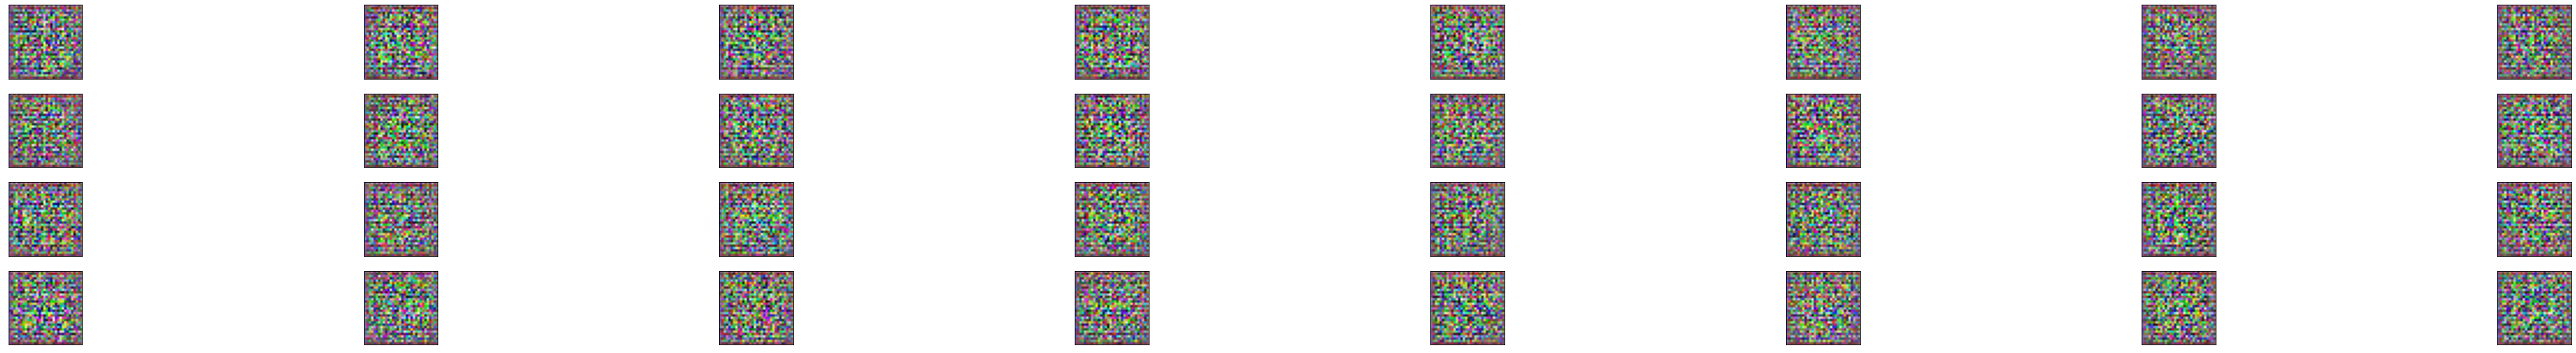

In [28]:
# see generated results

def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(img_size,8), nrows=4, ncols=8, sharey=True, sharex=True)

    for ax, img in zip(axes.flatten(), samples):
        
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

sample_size = img_size
z_size = 100
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.cpu()

_ = view_samples(-1, model(fixed_z))

In [26]:
print(torch.cuda.is_available())
print(torch.cuda)



False
<module 'torch.cuda' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/cuda/__init__.py'>


In [ ]:
# # deployment?

# from sagemaker.predictor import RealTimePredictor
# from sagemaker.pytorch import PyTorchModel

# class StringPredictor(RealTimePredictor):
#     def __init__(self, endpoint_name, sagemaker_session):
#         super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

# model = PyTorchModel(model_data=estimator.model_data,
#                      role = role,
#                      framework_version='0.4.0',
#                      entry_point='predict.py',
#                      source_dir='serve',
#                      predictor_cls=StringPredictor,)
# predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# predictor.endpoint
